# Data "Insecurity": How are Kagglers compensating for a lack of a graduate degree?

In [ ]:
# Standard imports
import numpy as np 
import pandas as pd 
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv('/kaggle/input/kaggle-survey-2020/kaggle_survey_2020_responses.csv')

# Extract questions, remove questions from data
questions = data.iloc[0, :]
data = data.drop(data.head(1).index)

# Introduction

Amongst holders of bachelor's degrees, how do younger, aspiring, data science professionals compare to their more seasoned counterparts? In this notebook, we set out to explore the differences in tools, technologies, and techniques utilized by these two groups. We focus in particular on the subset of survey respondents who hold a bachelor's degree, with the goal of exploring the idea that younger data science professionals without graduate degrees are under increasing pressure to learn a vast array of tools they can add to their resume, in order to remain competitive with the broader community in jop applications ("stat-stuffing" hypothesis). On the other hand, we also explore the idea that the respondents in the older subset of bachelor's degree holders are more established in their career, and do not feel the same pressure. 

Some of the many data science tools!
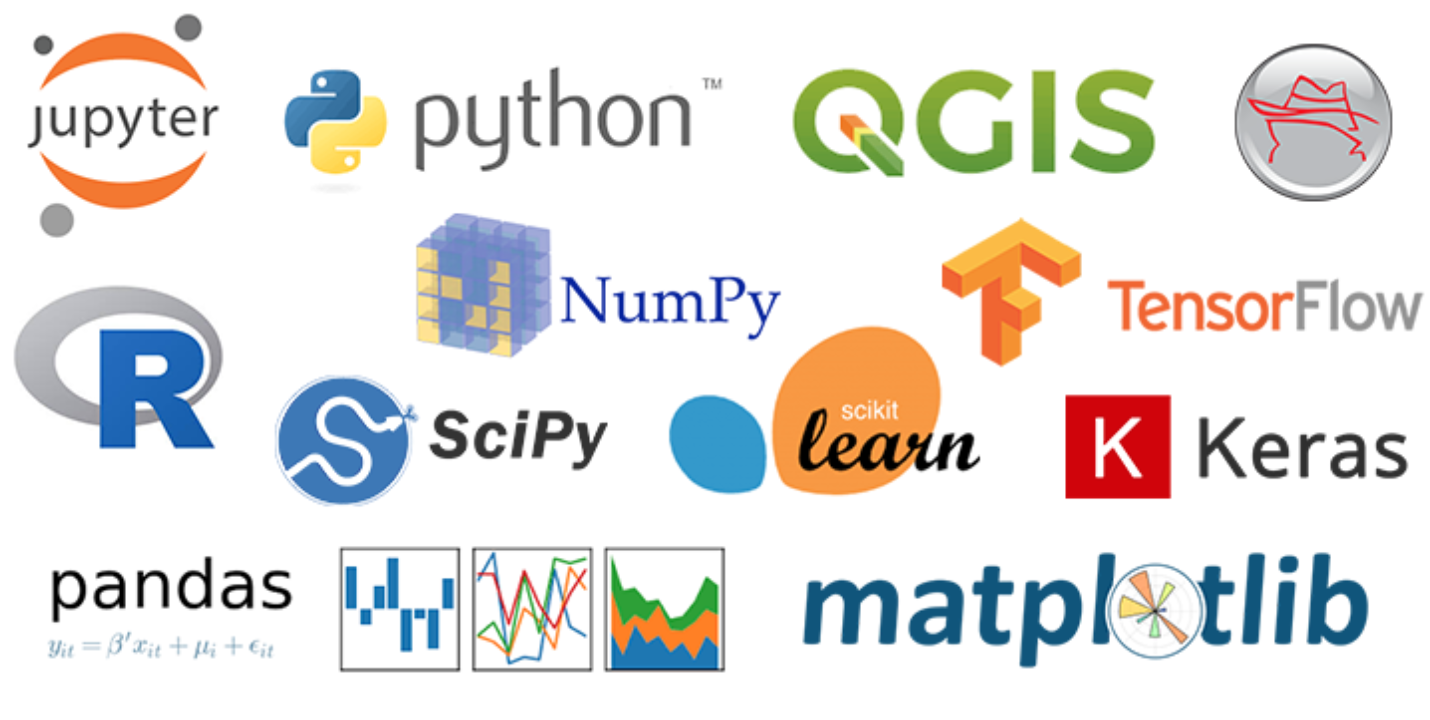

Source: https://gcmatos.github.io/Ecosystem-of-data-science-tools-Geoscientists/

In [ ]:
# Helper functions

def convert_mc_question(q_num, df):
    """
    Convert MC question to percent replied for each sub answer
    
    Args:
        q_num (str): question number to convert (i.e. 'Q7')
        df (pd.DataFrame): dataframe to pull questions from
    
    Returns:
        res (pd.Series): % replied yes to sub MC question
        
    """
    
    # Get % replied yes for each possible answer to MC question
    sub = df[df.columns[df.columns.str.contains(q_num)].tolist()].copy()
    pct = sub.count(axis = 0) / sub.shape[0]
    cols = sub.fillna(method='bfill', axis=0).iloc[0, :]
    res = pd.Series(data = pct.values, index = cols.values)

    return res

def comp_mc_questions_age(q_num, df):
    """
    Create dataframe to show % replied yes to each sub component of a MC
        question by the two age groups considered
    
    Args:
        q_num (str): question number to convert (i.e. 'Q7')
        df (pd.DataFrame): dataframe to pull questions from
        
    Returns:
        q_df (pd.DataFrame): df with value for question response filtered by age
    
    """
    
    # Create young and old groupings
    young = df[df['Q1'].isin(['18-21','22-24'])].copy()
    old = df[~df['Q1'].isin(['18-21','22-24'])].copy()
    
    # Get % replied yes for each possible answer to MC question
    young_srs = convert_mc_question(q_num, young)
    old_srs = convert_mc_question(q_num, old)
    
    # Create dataframe compatible with sns plotting functions
    young_df = pd.DataFrame({'age': ['18-24'] * len(young_srs), 'value': young_srs})
    old_df = pd.DataFrame({'age': ['25+'] * len(old_srs), 'value': old_srs})
    res_df = pd.concat([young_df, old_df], axis = 0)
    res_df = res_df.reset_index()
    res_df.columns = ['Category', 'Age', 'Value']
    
    return res_df

def get_mc_counts(q_num, df, col_subset = None):
    """
    Get number of questions respondent responded yes to for a particular question, 
        segmented by age
        
    Args:
        q_num (str): question number to convert (i.e. 'Q7')
        df (pd.DataFrame): dataframe to pull questions from
        col_subset (list): list of specific responses to consider in aggregation (None
            if not subsetting)

    Returns:
        res (dict): dict containing
            young (pd.Series): 
    
    """
    
    # Create young and old groupings
    young = df[df['Q1'].isin(['18-21','22-24'])].copy()
    old = df[~df['Q1'].isin(['18-21','22-24'])].copy()  
    
    # Get subsetted dataframe with relevant questions
    sub_young = young[young.columns[young.columns.str.contains(q_num)].tolist()].copy()
    sub_old = old[old.columns[old.columns.str.contains(q_num)].tolist()].copy()
    
    # Subset to certain responses of interest
    if col_subset != None:
        sub_young = sub_young[col_subset].copy() 
        sub_old = sub_old[col_subset].copy() 

    # Get sum for each respondent (row)
    young_sum = sub_young.count(axis = 1)
    old_sum = sub_old.count(axis = 1)
    
    # Combine young and old series
    res = {}
    res['young'] = young_sum
    res['old'] = old_sum
    
    return res

# Table of Contents

* [1) How to split our age groups?](#section-one)
* [2) Tools, techniques, and technologies among the two groups](#section-two)
* [3) Conclusions](#section-three)

<a id="section-one"></a>
## 1) How to split our age groups?

First, we aim to create a suitable grouping for the younger and older subset of the community with bachelor's degrees. Looking at the possible discrete separations we could create, the split between 18-24 and 25+ results in the most even split of total respondents with 3990 in the 18-24 category and 2998 respondents in the 24+ category. This split also has some intuitive appeal, as the 18-24 group largely comprises students and professionals in relatively junior roles or apsiring for them, while the 25+ group are generally more settled into their career.

In [ ]:
# Survey age group distribution plot
bach = data[data['Q4'] == 'Bachelor’s degree'].copy()
x_order = ['18-21','22-24','25-29','30-34','35-39','40-44','45-49','50-54','55-59','60-69','70+']
fig, ax = plt.subplots(figsize = (15, 5))
sns.countplot(data = bach, x = 'Q1', order = x_order)
plt.title('Age distribution amongst holders of bachelor\'s degrees')
ax.set_xlabel('Age (Years)')
ax.set_ylabel('Count')
plt.axvline(1.5, color = 'darkblue')

<a id="section-two"></a>
## 2) Tools, techniques, and technologies among the two groups

In this section, we dive into the questions proposed in the introduction given our newly established groups.  

### Tools: Programming languages

In [ ]:
# Programming language knowledge amongst younger and older gen
q7 = comp_mc_questions_age('Q7', bach)

sns.catplot(x = 'Category', y='Value', 
           hue = 'Age',data=q7, 
            kind='bar', aspect=15/5)
plt.ylabel('% of respondents')
plt.xlabel('Programming language')
plt.title('Programming language knowledge by age group')

From the above chart, we can see that the 18-24 group has a larger percentage of respondents claiming to know Python, C, C++, Java and MATLAB. Of the total languages surveyed, this is less than half (5 of 11 excluding None and Other).

In [ ]:
# How many respondents know multiple programming languages
q7_counts = get_mc_counts('Q7', bach)
young_df = pd.DataFrame({'Age': '18-24', 'Count': q7_counts['young']})
old_df = pd.DataFrame({'Age': '25+', 'Count': q7_counts['old']})
comp_df = pd.concat([young_df, old_df], axis = 0)

sns.boxplot(x = 'Age', y = 'Count', data = comp_df)
comp = pd.DataFrame({'18-24':q7_counts['young'].describe(), 
                     '25+':q7_counts['old'].describe()})

To understand individual respondent level data among the two groups more deeply, we also examine the distribution of total number of languages each respondent claims familiarity with amongst the two age groupings. The 18-24 group has a higher mean number of langugages reported compared to the 25+ group (2.56 vs 2.22), a higher 75th percentile, and a higher maximum reported number. It does appear the younger generation, as we have defined it, is slightly more focused on learning a large number of programming languages.

In [ ]:
# Counts for similiar DS languages (Python, R, MATLAB, Julia)
q7_ds_counts = get_mc_counts('Q7', bach, col_subset = ['Q7_Part_1', 'Q7_Part_2', 
                                                      'Q7_Part_8', 'Q7_Part_11'])
young_ds_df = pd.DataFrame({'Age': '18-24', 'Count': q7_ds_counts['young']})
old_ds_df = pd.DataFrame({'Age': '25+', 'Count': q7_ds_counts['old']})
comp_ds_df = pd.concat([young_ds_df, old_ds_df], axis = 0)
sns.boxplot(x = 'Age', y = 'Count', data = comp_ds_df)
comp_ds = pd.DataFrame({'18-24':q7_ds_counts['young'].describe(), 
                     '25+':q7_ds_counts['old'].describe()})
comp_ds

Another interesting question we can tackle is among programming languages that are widely used in data science applications, is there a tendency among our younger group to learn and use more on a regular basis as compared to their older peers? For this questions, we classify those languages as Python, R, Julia, and MATLAB. The answer seems to be there is not a substantial difference, and for the most part, the younger generation does not seem to be stuffing the survey results claiming to use a number of related programming languages on a regular basis (although their resumes may tell a different  story).

### Techniques: ML models

In [ ]:
# Programming language knowledge amongst younger and older gen
q17 = comp_mc_questions_age('Q17', bach)

ax = sns.catplot(x = 'Category', y='Value', 
           hue = 'Age',data=q17, 
            kind='bar', aspect=15/5)
plt.ylabel('% of respondents')
plt.xlabel('ML technique')
plt.title('ML technique knowledge by age group')
ax.set_xticklabels(rotation=90)

Both groups appear realtively familiar with the set of surveryed techniques. Interestingly, the 18-24 group appears to use neural network models, and more commonly used statistical learning models (regression, decision trees) more commonly than the 25+ group.

In [ ]:
# How many respondents know multiple programming languages
q17_counts = get_mc_counts('Q17', bach)
young_df = pd.DataFrame({'Age': '18-24', 'Count': q17_counts['young']})
old_df = pd.DataFrame({'Age': '25+', 'Count': q17_counts['old']})
comp_df = pd.concat([young_df, old_df], axis = 0)

sns.boxplot(x = 'Age', y = 'Count', data = comp_df)
comp = pd.DataFrame({'18-24':q17_counts['young'].describe(), 
                     '25+':q17_counts['old'].describe()})

We note that the average survery responder across the two groups claims to use around two ML techniques on a regular basis, which is another point against the "stat-stuffing" hypothesis I thought might be prevelant among the younger survey responders. The distributions in general are also nearly identical, with a lone outlier in the 25+ age grouping claiming regular use of all 11 non None ML techniques slightly skewing the 25+ distribution.

### Technologies: Cloud computing platforms

In [ ]:
# Programming language knowledge amongst younger and older gen
q26 = comp_mc_questions_age('Q26_A', bach)

ax = sns.catplot(x = 'Category', y='Value', 
           hue = 'Age',data=q26, 
            kind='bar', aspect=15/5)
plt.ylabel('% of respondents')
plt.xlabel('Cloud computing platform')
plt.title('Cloud computing platform knowledge by age group')
ax.set_xticklabels(rotation=90)

The more experienced group of Kagglers seems to regularly use cloud computing platforms more than the younger group. Interestingly, a larger number of respondents in the 25+ group also have no familarity with any of the cloud computing platforms.

In [ ]:
# How many respondents know multiple programming languages
q26_counts = get_mc_counts('Q26_A', bach)
young_df = pd.DataFrame({'Age': '18-24', 'Count': q26_counts['young']})
old_df = pd.DataFrame({'Age': '25+', 'Count': q26_counts['old']})
comp_df = pd.concat([young_df, old_df], axis = 0)

sns.boxplot(x = 'Age', y = 'Count', data = comp_df)
comp = pd.DataFrame({'18-24':q26_counts['young'].describe(), 
                     '25+':q26_counts['old'].describe()})

In general, it appears that the respondents in the older group are much more familiar with cloud computing technologies, and tend to be familiar with multiple (AWS, GCP, etc.) A likely result of younger Kagglers working as data analysts, or data scientists more focused on insight, and less on scalability of techniques / data storage. This point as well, is largely at odds with our "stat-stuffing" hypothesis.

<a id="section-three"></a>
## 3) Conclusions

Of the subset of questions analyzed, our results seem to point against the "stat-stuffing" hypothesis, that younger Kagglers without graduate degrees are learning a large (and sometimes unecessary) amount of tools, techniques, and technologies to remain competitive with their more experienced peers. In fact, they seem to generally be learning a broad range of tools much in the manner of a full-stack data scientist, and doing so in a similar manner to their older counter parts.